In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [3]:
df = pd.read_csv(url)

df.sample(5,random_state=5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
531,organic_search,technology,3,62453.0,unemployed,north_america,2,0.60,1
461,social_media,other,3,68122.0,self_employed,asia,4,0.26,1
785,events,retail,2,78769.0,student,south_america,3,0.92,1
664,events,technology,0,58247.0,employed,asia,4,0.81,0
655,events,NaN,1,82405.0,self_employed,europe,2,0.29,0


In [8]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [12]:
categorical = list(df.dtypes[df.dtypes=='object'].index)
numerical = list(df.dtypes[df.dtypes!='object'].index)
numerical.remove("converted")

In [50]:
print(categorical)
print(numerical)

['lead_source', 'industry', 'employment_status', 'location']
['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [14]:
for c in categorical:
    df[c] = df[c].fillna("NA")
for c in numerical:
    df[c] = df[c].fillna(0)
    

In [15]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train,df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_test['converted']
del df_val['converted']

In [33]:
from sklearn.metrics import auc

In [34]:
from sklearn.metrics import roc_auc_score

### Q1 ROC AUC feature importance

In [37]:

for i in numerical:
    auc2 = roc_auc_score( y_train, df_train[i])
    print(f"for column roc_auc_score {i}:", auc2)


for column roc_auc_score number_of_courses_viewed: 0.7635680590007088
for column roc_auc_score annual_income: 0.5519578313253012
for column roc_auc_score interaction_count: 0.738270176293409
for column roc_auc_score lead_score: 0.6144993577250176


### Q2 Training the model

In [41]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [43]:
dv = DictVectorizer(sparse=False)

In [44]:
train_dict = df_train[numerical+categorical].to_dict('records')

X_train =dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [45]:
val_dict = df_val[numerical+categorical].to_dict('records')

X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

churn_prediction = (y_pred>=0.5)

(y_val == churn_prediction).mean()

np.float64(0.6996587030716723)

In [46]:
auc_score = roc_auc_score(y_val, y_pred)

In [48]:
print(round(auc_score, 3))

0.817


### Q3  Precision and Recall

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

    0.145
    0.345
    0.545
    0.745


In [70]:
scores = []

# Creating an array of evenly-spaced probabilities from 0 to 1 (aka 0, 0.1, 0.2, ..., 0.99, 1)
thresholds = np.linspace(0.0, 1, 101)

# Printing true positives & negatives, false positives & negatives for each rate 
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    # List of tuples is created per threshold
    scores.append((t, tp, fp, fn, tn))

In [71]:
# Creating a dataframe for these scores so that we are able model the TPRs and FPRs for each threshold
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

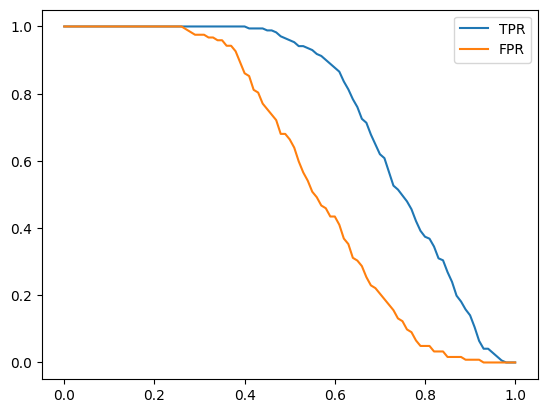

In [72]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [69]:
thresholds = np.linspace(0.0, 1, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

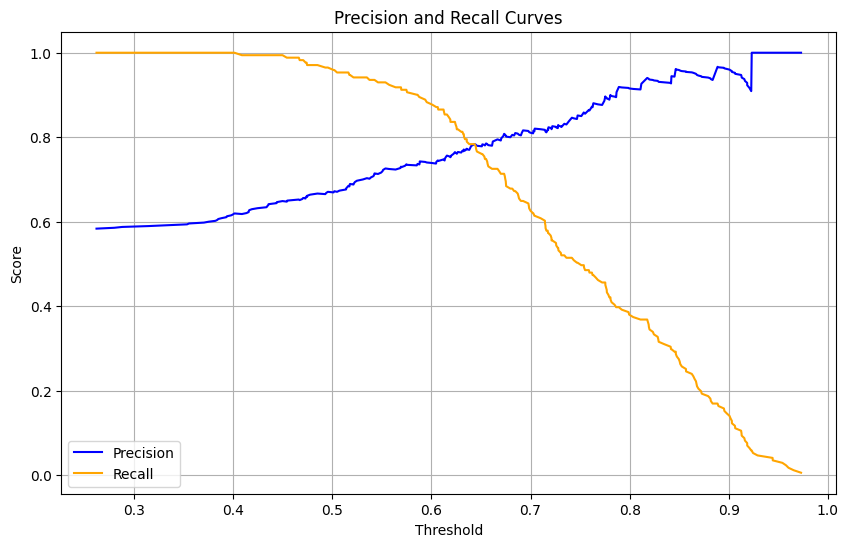

Intersection points: [np.float64(0.6400326476172833)]


In [81]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

# Adding the last threshold which corresponds to 1.0
thresholds = np.append(thresholds, 1.0)

# Plotting Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds[:293], precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds[:293], recalls[:-1], label='Recall', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.grid()
plt.legend()
plt.show()

# Finding intersection point
intersections = []

for i in range(len(precisions) - 1):
    if (precisions[i] - recalls[i] >= 0 and precisions[i+1] - recalls[i+1] < 0) or (precisions[i] - recalls[i] < 0 and precisions[i+1] - recalls[i+1] >= 0):
        intersections.append(thresholds[i])

# Print the intersection points
print(f"Intersection points: {intersections}")

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 F 1 = 2 ⋅ P ⋅ R P + R 

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

    0.14
    0.34
    0.54
    0.74


.

Precision=True Positives (TP)+False Positives (FP)True Positives (TP)​

Recall: The ratio of true positive predictions to the total actual positives. It shows how many of the actual positive cases were correctly predicted.

Recall=True Positives (TP)+False Negatives (FN)True Positives (TP)​ 

In [98]:
scores1 = []

# Creating an array of evenly-spaced probabilities from 0 to 1 (aka 0, 0.1, 0.2, ..., 0.99, 1)
thresholds = np.linspace(0.0, 1, 101)

# Printing true positives & negatives, false positives & negatives for each rate 
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    if tp != 0.0 and fp != 0.0:
        Precision = tp/(tp +fp)
    if tp != 0.0 and fn != 0.0:
        Recall = tp/ (tp+fn)

    F1 = 2 * ((Precision * Recall) / (Precision + Recall))
    # List of tuples is created per threshold
    scores1.append((t, tp, fp, fn, tn, Precision, Recall, F1))

In [100]:
# Creating a dataframe for these scores so that we are able model the TPRs and FPRs for each threshold
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'Precision', 'Recall', 'F1']
df_scores1 = pd.DataFrame(scores1, columns=columns)

In [101]:
df_scores1.F1.max()

np.float64(0.8124999999999999)

In [107]:
df_scores1.query("F1 == 0.8124999999999999")

,threshold,tp,fp,fn,tn,Precision,Recall,F1
57,0.57,156,57,15,65,0.732394,0.912281,0.8125


### Q5 Fold CV

In [110]:

from sklearn.model_selection import KFold

In [112]:


X = df_full_train.drop("converted", axis=1)
y = df_full_train['converted']
# Encode categorical features if necessary, for example
X = pd.get_dummies(X)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# List to store AUC scores
auc_scores = []

# K-Folds cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predict probabilities on validation set
    y_val_pred_probs = model.predict_proba(X_val)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_val, y_val_pred_probs)
    auc_scores.append(auc)

# Print the AUC scores for each fold
print(f"AUC Scores for each fold: {auc_scores}")
print(f"Mean AUC Score: {sum(auc_scores) / len(auc_scores):.3f}")

AUC Scores for each fold: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Mean AUC Score: 0.822


In [113]:
# Calculate and print the standard deviation of the AUC scores
std_dev_auc = np.std(auc_scores)
print(f"AUC Scores for each fold: {auc_scores}")
print(f"Mean AUC Score: {np.mean(auc_scores):.3f}")
print(f"Standard Deviation of AUC Scores: {std_dev_auc:.3f}")

AUC Scores for each fold: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Mean AUC Score: 0.822
Standard Deviation of AUC Scores: 0.036


### Q6 : Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

    0.000001
    0.001
    1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [122]:


def train_model_on_different_c(c):
    X = df_full_train.drop("converted", axis=1)
    y = df_full_train['converted']
    # Encode categorical features if necessary, for example
    X = pd.get_dummies(X)

    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    # List to store AUC scores
    auc_scores = []

    # K-Folds cross-validation
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
        # Train the model
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)
    
        # Predict probabilities on validation set
        y_val_pred_probs = model.predict_proba(X_val)[:, 1]
        
        # Calculate AUC
        auc = roc_auc_score(y_val, y_val_pred_probs)
        auc_scores.append(auc)
    std_dev_auc = np.std(auc_scores)
    # Print the AUC scores for each fold
    print(f"AUC Scores for each fold: {auc_scores}")
    print(f"Mean AUC Score: {sum(auc_scores) / len(auc_scores):.3f}")
    print(f"std for auc_scores:  {std_dev_auc:.3f}")

In [123]:
C = [0.000001, 0.001, 1]

for i in C:
    print(f"For C {i}: ")
    train_model_on_different_c(i)

For C 1e-06: 
AUC Scores for each fold: [0.5572098563239782, 0.5191961842208147, 0.5894909688013137, 0.5582191780821917, 0.5769230769230769]
Mean AUC Score: 0.560
std for auc_scores:  0.024
For C 0.001: 
AUC Scores for each fold: [0.8608650338718081, 0.8967081085307685, 0.822816482915005, 0.8539850560398504, 0.9000154774802662]
Mean AUC Score: 0.867
std for auc_scores:  0.029
For C 1: 
AUC Scores for each fold: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Mean AUC Score: 0.822
std for auc_scores:  0.036
